In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz


def to_datetime(dates, tz_aware=True):
    """
    Standardizes the various types of string datetime formats
    """
    dt = []
    for i in dates:
        i = i.replace('T','_')
        i = i.replace('-','')
        i = i.replace(' ', '_')
        try:
            i_dt = datetime.strptime(i, '%Y%m%d_%H:%M:%S')
        except:
            print(i)
        if tz_aware:
            # tz = pytz.timezone('US/Eastern')
            tz = pytz.timezone('UTC')
            i_dt = tz.localize(i_dt)
            dt.append(i_dt.astimezone(pytz.timezone('US/Eastern')))
        else:
            dt.append(i_dt)
    return np.array(dt)  

### ONLY RUN ONCE! ###
#download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

/Users/wfairman/opt/anaconda3/envs/lab2/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


making new app


TypeError: Reference.order_by_child() missing 1 required positional argument: 'path'

## Bathymetry Data
Data collection occurs between May 22th and May 25th. Data collection occured on pond 24 and 38.

In [132]:
data = db.reference('LH_Farm/bathymetry/').order_by_key().start_at('20240522_').get()

In [24]:
print(list(data.keys()))

# GET ALL PONDS IN BATHYMETRY
ponds = []
for i in data:
    pond_id = data[i]['pid']
    if pond_id not in ponds:
        ponds.append(pond_id)

print(ponds)
print(data['20240522_20:25:24'])
print(data['20240522_20:25:56'])

['20240522_20:19:13', '20240522_20:19:22', '20240522_20:19:32', '20240522_20:19:43', '20240522_20:19:55', '20240522_20:20:06', '20240522_20:20:46', '20240522_20:20:56', '20240522_20:21:07', '20240522_20:21:18', '20240522_20:22:32', '20240522_20:25:24', '20240522_20:25:56', '20240522_20:26:23', '20240522_20:26:34', '20240522_20:27:01', '20240522_20:27:18', '20240522_20:27:37', '20240522_20:27:55', '20240522_20:28:06', '20240522_20:28:17', '20240522_20:28:28', '20240522_20:28:39', '20240522_20:29:20', '20240522_20:29:31', '20240522_20:29:42', '20240522_20:29:53', '20240522_20:30:04', '20240522_20:30:15', '20240522_20:30:37', '20240522_20:30:58', '20240522_20:31:07', '20240522_20:31:58', '20240522_20:32:21', '20240522_20:32:53', '20240522_20:33:19', '20240522_20:33:57', '20240522_20:34:05', '20240522_20:34:45', '20240522_20:35:13', '20240522_20:35:23', '20240522_20:35:59', '20240522_20:36:10', '20240522_20:36:38', '20240522_20:37:09', '20240522_20:37:20', '20240522_20:37:48', '20240522_20

In [73]:
def clean_pids(x, dt):

    for i in range(len(x)):
        if x[i] == 'unknown':
            if dt[i] < pytz.timezone('US/Eastern').localize(datetime(2025, 5, 22, 16, 51)):
                x[i] = '38'
            else:
                x[i] = '24'
    
    return x

In [71]:
pytz.timezone('US/Eastern').localize(datetime(2025, 5, 22, 16, 51))

datetime.datetime(2025, 5, 22, 16, 51, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

In [121]:
dt = to_datetime(data.keys())

initial_pressure = np.array([data[i]['init_pressure'] for i in data]).astype('float')
pressure = np.array([data[i]['pressure'][1] for i in data]).astype('float')
depth = (pressure - initial_pressure) * 0.010227

initial_DO = np.array([data[i]['init_do'] for i in data]).astype('int')
do = np.array([data[i]['do'][1] for i in data]).astype('float') / initial_DO

latitude = np.array([round(float(data[i]['lat']), 4) for i in data])
longitude = np.array([round(float(data[i]['lng']), 4) for i in data])
coordinates = [(float(latitude[i]), float(longitude[i])) for i in range(len(latitude))]
pids = np.array([data[i]['pid'] for i in data])
pids = clean_pids(pids, dt)

temperature = np.array([data[i]['temp'][1] for i in data]).astype('float')



df = pd.DataFrame({'time': dt, 'initial_pressure':initial_pressure, 'pressure':pressure, 'depth':depth,
                   'initial_DO':initial_DO, 'DO':do, 'temperature':temperature,
                   'coordinates':(coordinates), 'latitude':latitude, 'longitude':longitude, 'pond_id':pids})

# 'latitude':latitude, 'longitude':longitude

df.to_csv('bathymetry.csv')

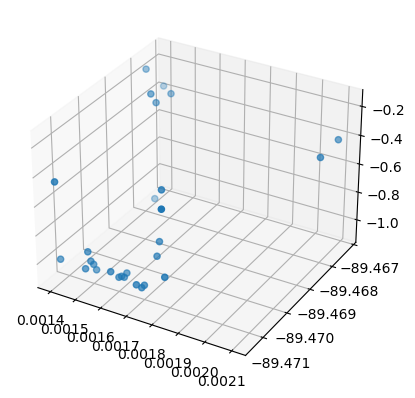

In [130]:
coordinate_array = pd.unique(df[df.pond_id == '38'].coordinates)
depth = np.zeros(len(coordinate_array))
for i in range(len(coordinate_array)):
    depth[i] = -1 * df[df.coordinates == coordinate_array[i]].depth.max()

x = [i[0] for i in coordinate_array]
y = [i[1] for i in coordinate_array]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, depth)
plt.show()

In [97]:
nx, ny = (3, 2)
print(nx)
x = np.linspace(0, 1, nx)
print(x)
y = np.linspace(0, 1, ny)
print(y)
xv, yv = np.meshgrid(x, y)

print(xv)
print(yv)

3
[0.  0.5 1. ]
[0. 1.]
[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]


<Figure size 640x480 with 0 Axes>

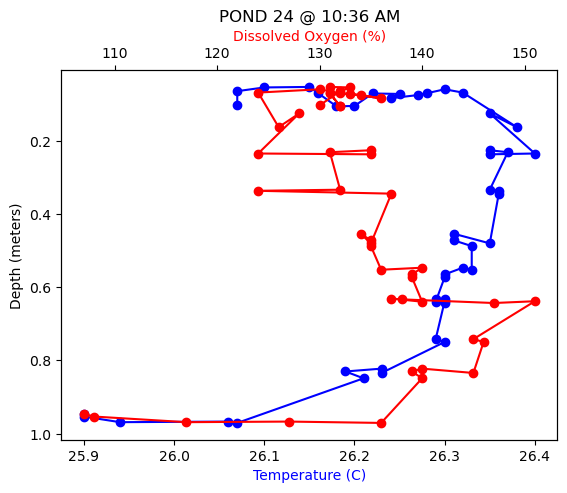

In [20]:
def depth_plot(data, pond_id, start, end):
    
    pond_id = str(pond_id)
    keys = np.array(list(data.keys()))
    dt = to_datetime(keys)
    start = pytz.timezone('UTC').localize(start)
    end = pytz.timezone('UTC').localize(end)

    initPressure = np.array([data[i]['init_pressure'] for i in data]).astype('float')
    initPressure = initPressure[0] #only grab the first init

    pressure = np.array([data[i]['pressure'][1] for i in data]).astype('float')
    depth = (pressure - initPressure) * 0.010227
    
    temperature = np.array([data[i]['temp'][1] for i in data]).astype('float')
    
    do = np.array([data[i]['do'][1] for i in data]).astype('float')
    pids = np.array([data[i]['pid'] for i in data])

    plt.figure()
    fig, ax1 = plt.subplots()
    plt.gca().invert_yaxis()
    ax2 = ax1.twiny()
    ax1.scatter(temperature[(pids == pond_id) & (dt > start) & (dt < end)], depth[(pids == pond_id) & (dt > start) & (dt < end)], color='b')
    ax1.plot(temperature[(pids == pond_id) & (dt > start) & (dt < end)], depth[(pids == pond_id) & (dt > start) & (dt < end)], color='b')
    ax2.scatter(do[(pids == pond_id) & (dt > start) & (dt < end)], depth[(pids == pond_id) & (dt > start) & (dt < end)], color='r')
    ax2.plot(do[(pids == pond_id) & (dt > start) & (dt < end)], depth[(pids == pond_id) & (dt > start) & (dt < end)], color='r')


    ax1.set_xlabel('Temperature (C)', color='b')
    ax2.set_xlabel('Dissolved Oxygen (%)', color='r')
    ax1.set_ylabel('Depth (meters)')

    # print(keys[(pids == pond_id)])

    
    

depth_plot(data, 24, datetime(2024, 5, 24, 15, 36), datetime(2024, 5, 24, 15, 53))
plt.title("POND 24 @ 10:36 AM")
# plt.savefig('bathy_data/pond_24_10_35.png')
plt.show()


{'do': [124, 123], 'heading': '0', 'init_do': '119', 'init_pressure': '995.43', 'lat': '37.701896', 'lng': '-89.468101', 'pid': '24', 'pressure': [1011.54, 1011.07], 'sid': '4', 'temp': [27.32, 27.6], 'type': 'bathy'}
[27.6, 27.39, 27.34, 27.47, 27.69, 27.72, 27.62, 27.67, 27.55, 27.02, 26.7, 26.79, 26.98, 27.07, 27.1, 27.08, 27.04, 26.99, 26.92, 26.85, 26.31, 26.51, 26.38, 26.39, 26.27, 26.27, 26.28, 26.3, 26.25, 26.29, 26.23, 26.19, 26.16, 26.14, 26.16, 26.12, 26.1, 26.1, 26.08, 26.09, 26.08, 26.06, 26.05, 26.04, 26.06, 26.02, 26.04, 26.03, 26.05, 26.05, 26.05, 26.03, 26.01, 26.02, 26.05, 26.03, 26.01, 26.03, 26.05, 26.0, 25.97, 25.98, 25.97, 25.97, 25.97, 25.96, 25.96, 25.95, 25.95, 25.94, 25.96, 25.97, 25.96, 25.96, 25.96, 25.95, 25.96, 25.93, 25.93, 25.94, 25.86, 25.87, 25.64, 25.63, 25.58, 25.56, 25.54, 25.53, 25.52, 25.48, 25.46, 25.44, 25.44, 25.41, 25.41, 25.42, 25.46, 25.42, 25.36, 25.35, 25.34, 26.0, 26.06, 26.09, 25.95, 26.01, 26.03, 26.03, 26.01, 25.93, 25.75, 25.58, 25.61

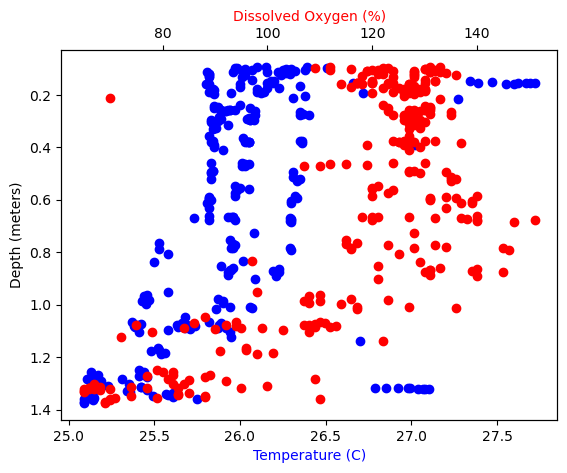

In [17]:
keys = np.array(list(data.keys())).astype('str')
dt = to_datetime(keys)
start = pytz.timezone('America/New_York').localize(datetime(2024, 5, 24, 8, 47))
spot = keys[dt > start]

print(data[spot[0]])
initPressure = float(data[spot[0]]['init_pressure'])
pressure = np.array([data[i]['pressure'][1] for i in spot])
temperature = np.array([data[i]['temp'][1] for i in spot])
do = np.array([data[i]['do'][1] for i in spot])
depth = (pressure - initPressure) * 0.010227

print([data[i]['temp'][1] for i in spot])



fig, ax1 = plt.subplots()
plt.gca().invert_yaxis()
ax2 = ax1.twiny()
ax1.scatter(temperature, depth, color='b')
ax2.scatter(do, depth, color='r')

ax1.set_xlabel('Temperature (C)', color='b')
ax2.set_xlabel('Dissolved Oxygen (%)', color='r')
ax1.set_ylabel('Depth (meters)')

plt.show()


# plt.figure()
# plt.scatter(temperature, depth)
# plt.scatter(do, depth)
# plt.gca().invert_yaxis()
# plt.title("Thermocline")
# plt.ylabel("Depth (meters)")
# plt.xlabel("Temperature (celcius)")
# plt.show()

## GPS Data

In [133]:
data = db.reference('LH_Farm/gps/').order_by_key().start_at('20240522_').get()

In [131]:
dt = to_datetime(data.keys())

latitude = np.array([round(float(data[i]['lat']), 4) for i in data])
longitude = np.array([round(float(data[i]['lng']), 4) for i in data])
coordinates = [(float(latitude[i]), float(longitude[i])) for i in range(len(latitude))]




df = pd.DataFrame({'time': dt, 'coordinates':(coordinates), 'latitude':latitude, 'longitude':longitude})
df.to_csv('gps.csv')